# **本Notebookのゴール（EDA / 安全性チェック）**
このNotebookの目的は、uplift modeling（Top-K ターゲティング最適化）に進む前段階として、  「そもそもこのデータで因果効果（uplift）をモデリングできそうか？」を確認するためのEDAです。

観察データでは、介入がランダムに付与されていない可能性があるため、  
いきなり CATE/uplift モデルを当てる前に、まず **選択バイアスの有無と程度、そして比較可能性（overlap）を点検**します。

本Notebookにおける分析は、以下の4点を順に確認します。

1. **選択バイアスの有無と大きさ**  
   - 介入群と非介入群の共変量分布がどれだけ違うか  
   - **SMD（標準化平均差）**などで定量化して把握する

2. **overlap（比較可能領域）の有無**  
   - 傾向スコア（PS）の分布に共通サポートがあるか  
   - 極端な PS がどれくらいあるかを確認し、**固定 trimming** の妥当性を検討する

3. **重み付けによるバランス改善と安定性の確認**  
   - overlap（比較可能領域）を重視する重み付け（overlap weights）を適用したときに、  
     共変量バランスが改善し、推定が安定しそうかを確認する  
   - **Love plot（SMD）**と **ESS（実効サンプルサイズ）**で診断する  
   - ※ overlap が限定的な場合の外挿を避けるため、  
     **比較可能な overlap 領域（ATO 寄り）**を意識した設計とする

4. **効果の異質性（heterogeneity）の兆候**  
   - 介入効果が一様ではなく、対象によって差がありそうかを簡易に確認する  
   - （ここで強い結論を出すのではなく、「次の uplift モデリングが意味を持ちそうか」の確認）


---

これらの診断結果に基づいて、次のNotebookでのモデリング方針を決定します。

| 設計の判断項目 | EDAで確認すること | 決めること |
|:---|:---|:---|
| **推定対象** | overlap の広さ | 母集団全体（ATE）か、比較可能領域（ATO寄り）か |
| **Trimming** | 極端PSの割合・影響 | trimming閾値（0.03 / 0.05 / 0.10 等） |
| **重み付け** | SMD・ESSのバランス | IPW / Overlap weights / マッチング / なし |
| **推定手法** | バランス・サンプルサイズ | T-Learner / DR-Learner 等 |
| **評価指標** | 選択バイアスの程度 | AUUC/Qini の位置づけ、Policy Value を主指標にするか |


本Notebookは「モデルを当てる」ためではなく上記の設計判断に必要な情報を得るための分析です。



# **0. データセットと事前準備**

本分析では **IHDP（Infant Health and Development Program）** データセットを使用します。  
データの背景・構成の詳細は [README](./README.md#データセット) を参照してください。

In [12]:
#必要ライブラリインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from typing import List, Optional, Tuple, Dict
from sklearn.model_selection import StratifiedKFold, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.ticker as mticker

#設定
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 50)

COLOR_PALETTE = {0: "steelblue", 1: "darkorange", "0": "steelblue", "1": "darkorange"}

SEED = 42
COL_ID = "user_id"
COL_TREAT = "treatment"
COL_Y = "outcome"
COL_TRUE_UPLIFT = "true_uplift"

In [13]:
def load_ihdp() -> pd.DataFrame:
    """
    データ取得し変数名リネーム
    """
    url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
    print(f"Loading data from {url} ...")
    df = pd.read_csv(url, header=None)

    base_cols = ["treatment", "y", "y_cf", "mu0", "mu1"] + [f"x{i+1}" for i in range(25)]
    df.columns = base_cols
    df.insert(0, COL_ID, range(len(df)))

    df.rename(columns={"treatment": COL_TREAT, "y": COL_Y, "mu0": "true_mean_control", "mu1": "true_mean_treated"}, inplace=True)
    df[COL_TRUE_UPLIFT] = df["true_mean_treated"] - df["true_mean_control"]

    cov_map = {
        "x1": "birth_weight",
        "x2": "head_circumference",
        "x3": "weeks_preterm",
        "x4": "birth_order",
        "x5": "neonatal_health",
        "x6": "mother_age",
        "x7": "child_sex",
        "x8": "is_twin",
        "x9": "mother_married",
        "x10": "mother_edu_low",
        "x11": "mother_edu_hs",
        "x12": "mother_edu_college",
        "x13": "mother_smoke",
        "x14": "mother_drink",
        "x15": "mother_work_pregnancy",
    }
    for i in range(16, 26):
        cov_map[f"x{i}"] = f"site_{i-15}"
    df.rename(columns=cov_map, inplace=True)
    return df

def get_feature_cols(df: pd.DataFrame) -> List[str]:
    ignore = [
        COL_ID, COL_TREAT, COL_Y, COL_TRUE_UPLIFT,
        "true_mean_control", "true_mean_treated",
        "y_cf", "outcome_counterfactual",
        "ps_score"
    ]
    return [c for c in df.columns if c not in ignore]

#データロード
df = load_ihdp()

#必要変数のみ取得
features = get_feature_cols(df)

#データ確認
print(f"データ件数: {df.shape[0]}  カラム数: {df.shape[1]}")
display(df.head())
display(df[COL_TREAT].value_counts())

#アウトカムの基礎統計量確認
display(df.groupby(COL_TREAT)[COL_Y].describe())

#欠損確認
missing = df.isnull().sum()[df.isnull().sum() > 0]
if missing.empty:
  print('欠損はありません')
else:
  print(missing)




Loading data from https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv ...
データ件数: 747  カラム数: 32


,user_id,treatment,outcome,y_cf,true_mean_control,true_mean_treated,birth_weight,head_circumference,weeks_preterm,birth_order,neonatal_health,mother_age,child_sex,is_twin,mother_married,mother_edu_low,mother_edu_hs,mother_edu_college,mother_smoke,mother_drink,mother_work_pregnancy,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,true_uplift
0,0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,0,1,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,3.586200
1,1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,0,0,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0.926659
2,2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,0,0,1,0,0,0,2,0,1,0,1,1,0,0,0,0,0,0,4.551081
3,3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,0,0,0,0,1,1,2,0,1,0,1,1,0,0,0,0,0,0,4.644387
4,4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,0,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0,4.506946


,count
treatment,
0,608
1,139


,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,608.0,2.411297,1.595977,-1.543902,1.449381,2.223557,3.082210,11.268228
1,139.0,6.432418,1.108928,3.287666,5.834726,6.307376,7.335885,9.314615


欠損はありません


# **1. 選択バイアスの有無と大きさ確認**


## 1.1 可視化による各共変量の分布確認
まずは可視化によりバイアスの有無を直感的に確認する。  
介入群と対照群における各共変量の分布はアウトカムを可視化によって比較し、  
介入割当が共変量に依存していそうか（選択バイアスがありそうか）をチェックする。

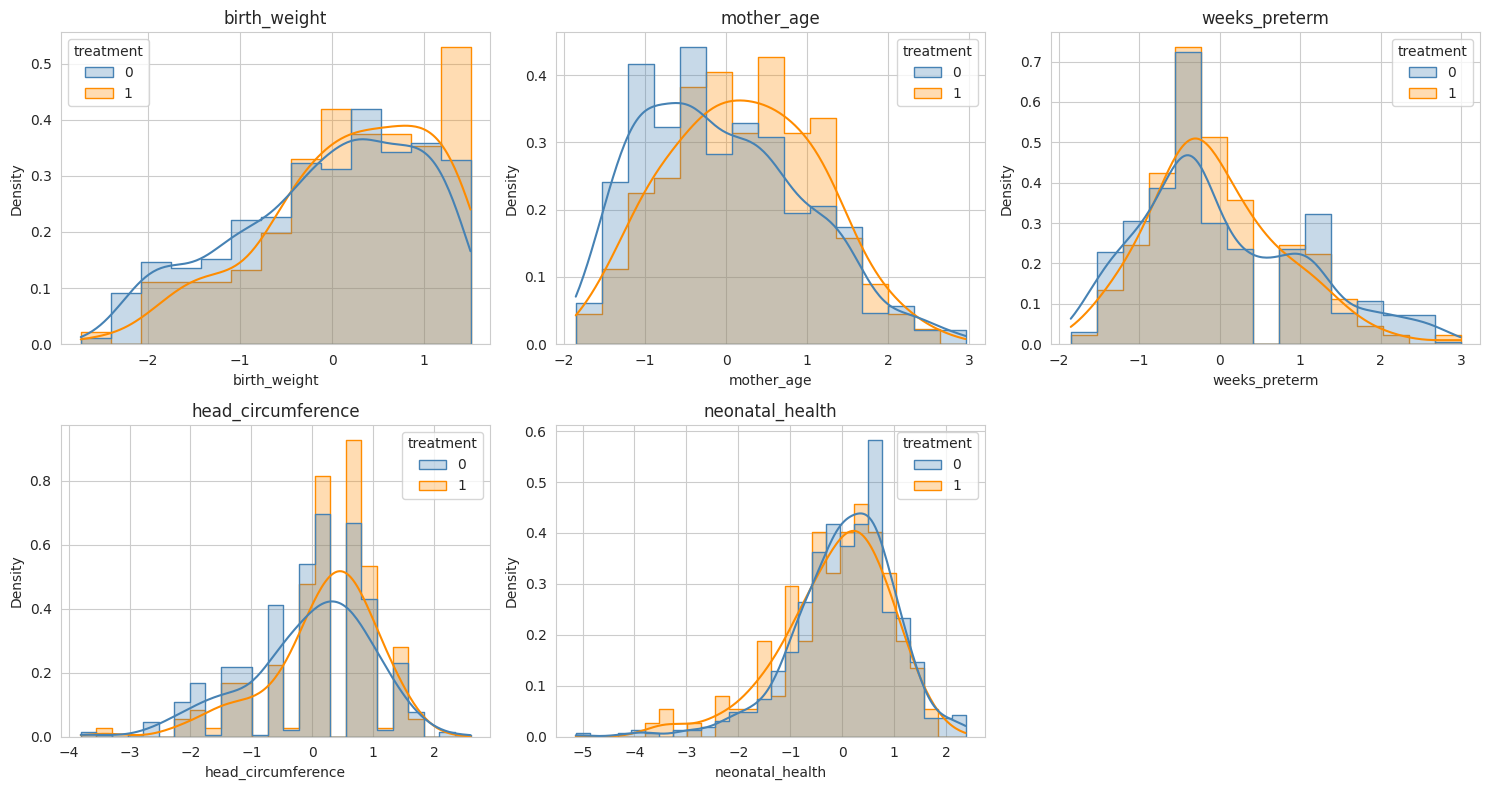

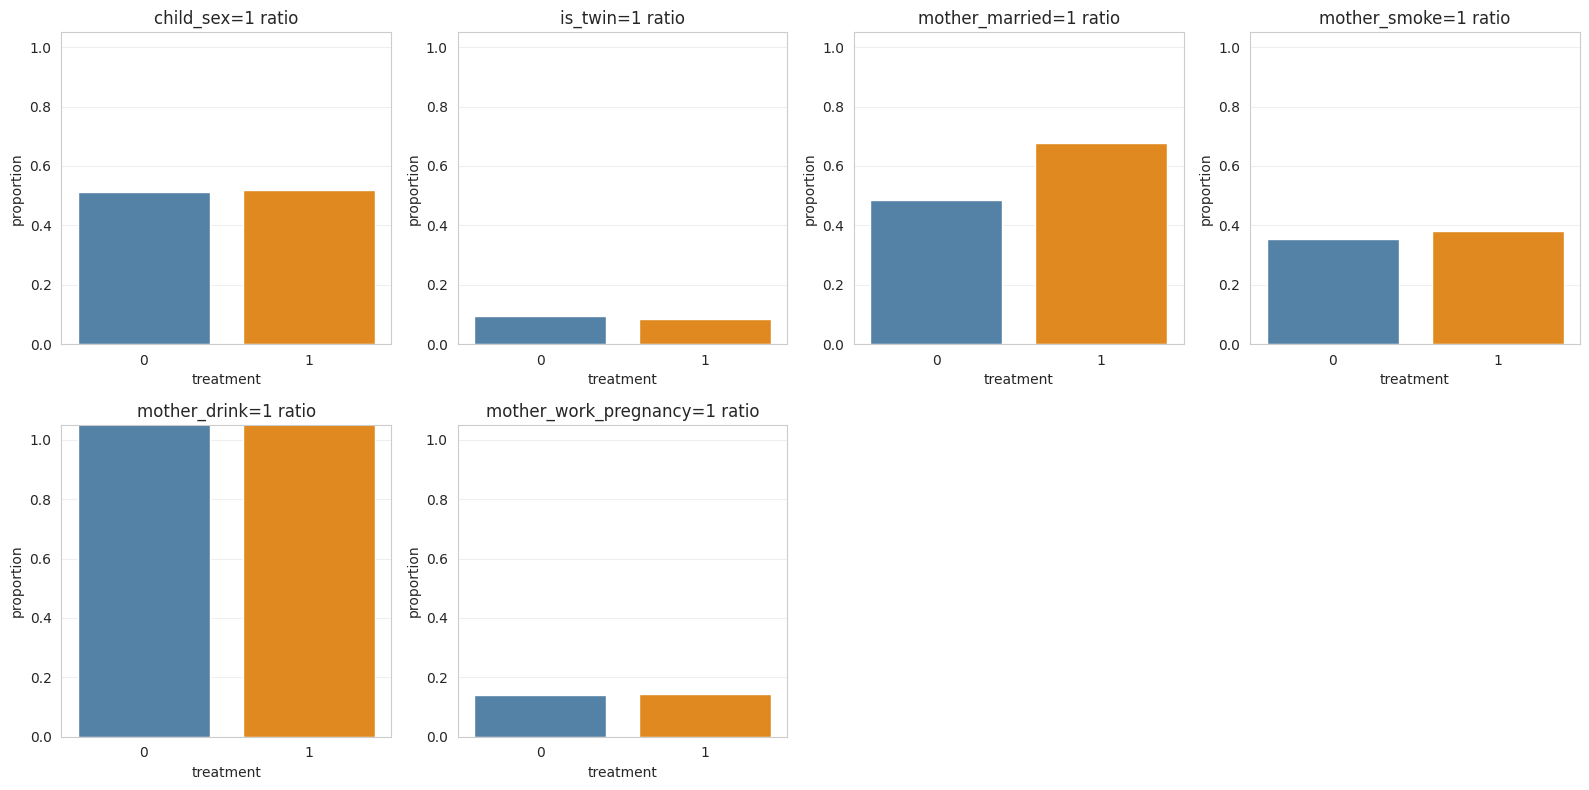

In [14]:
# 各共変量の分布確認
def plot_continuous_comparison(df: pd.DataFrame, cols: List[str], hue_col: str = COL_TREAT, cols_per_row: int = 3):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print("No cols.")
        return

    n = len(cols)
    n_rows = int(np.ceil(n / cols_per_row))
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(5 * cols_per_row, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(cols):
        ax = axes[i]
        sns.histplot(
            data=df, x=col, hue=hue_col,
            kde=True, element="step", stat="density", common_norm=False,
            palette=COLOR_PALETTE, ax=ax, alpha=0.3
        )
        ax.set_title(col)
        ax.set_ylabel("Density")
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

def plot_binary_comparison(df: pd.DataFrame, cols: List[str], hue_col: str = COL_TREAT, cols_per_row: int = 4):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print("No cols.")
        return

    n = len(cols)
    n_rows = int(np.ceil(n / cols_per_row))
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(4 * cols_per_row, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(cols):
        ax = axes[i]
        prop = df.groupby(hue_col)[col].mean().reset_index()
        prop.columns = [hue_col, "proportion"]
        sns.barplot(data=prop, x=hue_col, y="proportion", hue=hue_col, palette=COLOR_PALETTE, ax=ax, legend=False)
        ax.set_title(f"{col}=1 ratio")
        ax.set_ylim(0, 1.05)
        ax.grid(axis="y", alpha=0.3)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

# notebook上の見やすさを考慮して代表的な共変量のみに限定。本来は全共変量を確認すべき
cont_cols = ["birth_weight", "mother_age", "weeks_preterm", "head_circumference", "neonatal_health"]
bin_cols = ["child_sex", "is_twin", "mother_married", "mother_smoke", "mother_drink", "mother_work_pregnancy"]

plot_continuous_comparison(df, [c for c in cont_cols if c in df.columns])
plot_binary_comparison(df, [c for c in bin_cols if c in df.columns])


## 1.2 調整なしのアウトカム比較
介入群と対照群のアウトカムを単純に比較（この結果は介入効果だけでなく選択バイアスや交絡の影響も含む）

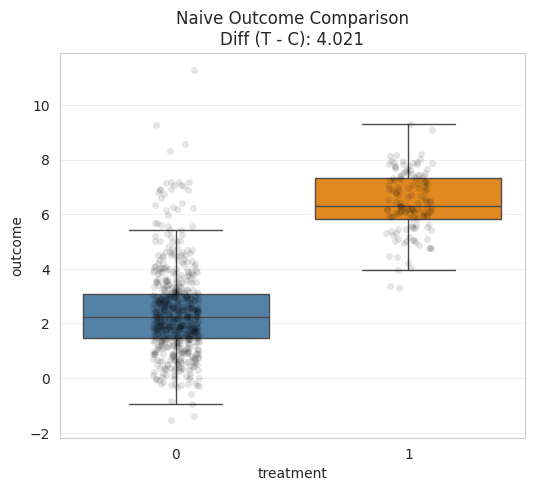

In [15]:
def visualize_naive_outcome(df: pd.DataFrame, treatment_col=COL_TREAT, outcome_col=COL_Y):
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        data=df, x=treatment_col, y=outcome_col, hue=treatment_col,
        palette=COLOR_PALETTE, showfliers=False, legend=False
    )
    sns.stripplot(data=df, x=treatment_col, y=outcome_col, color="black", alpha=0.1, jitter=True)

    treated_mean = df[df[treatment_col] == 1][outcome_col].mean()
    control_mean = df[df[treatment_col] == 0][outcome_col].mean()
    diff = treated_mean - control_mean

    plt.title(f"Naive Outcome Comparison\nDiff (T - C): {diff:.3f}")
    plt.grid(axis="y", alpha=0.3)
    plt.show()

visualize_naive_outcome(df)



## 1.3 変数の役割の把握（SMD × Outcome相関）

このセルでは、uplift modelingに入る前に **「どの共変量がバイアス要因か」「どの共変量が予後因子か」** を把握し**調整すべき変数・注意すべき変数** を見える化するステップです。

### 因果推論における変数の分類

| 分類 | Tに影響 | Yに影響 | 調整の扱い |
|:---|:---:|:---:|:---|
| **交絡変数** | ○ | ○ | 必ず調整（バイアス除去） |
| **予後因子** | × | ○ | 調整すると精度向上 |
| **操作変数（IV）** | ○ | × | 調整に入れると分散増大・overlap悪化 |
| **無関係** | × | × | 調整不要 |

本分析では、SMD（Tとの関連）× Outcome相関（Yとの関連）の散布図で可視化することで、各共変量がどの分類に近いかを把握します。

※操作変数について補足<br>
操作変数を傾向スコアモデルに含めると、「処置の予測精度」が無駄に上がりすぎてしまい、傾向スコアが0か1に張り付く（Overlapが悪化する）原因になる。これにより、推定量の分散が増大したり、未観測交絡がある場合にバイアスを増幅させたりするリスクがあるので扱いは注意が必要

### 1) メトリクス作成（build_variable_metrics_df）
各共変量について、以下を計算して `metrics_df` を作る。

- **SMD (Bias)**：介入群 vs 対照群の標準化平均差（絶対値）で両群の分布の差を表す  
  → treatment との関連が強い＝**選択バイアス/交絡の疑いが強いといえる**  
- **Correlation (Outcome)**：アウトカムとの相関（絶対値）  
  → アウトカムへの説明力が強い＝**予後因子（推定精度の改善に寄与）**


### 2) 散布図で可視化（plot_variable_selection_scatter）
- **x軸：SMD (Bias)**（treatmentとの関連）
- **y軸：Correlation (Outcome)**（outcomeとの関連）
- 目安として **SMD=0.1** の縦線を引き、バイアスが大きい変数を目立たせる

この図の読み方：

| 位置 | 変数分類 | 扱い |
|:---|:---|:---|
| **右上（SMD大 × 相関大）** | 交絡変数 | **必ず調整候補** |
| **左上（SMD小 × 相関大）** | 予後因子 | **精度改善に効くのでモデルに入れたい** |
| **右下（SMD大 × 相関小）** | 操作変数の可能性 | **傾向スコアが極端になりoverlap悪化の原因になりうるので慎重に判断する** |
| **左下（SMD小 × 相関小）** | 無関係 | 調整の優先度が低い |



In [16]:
def build_variable_metrics_df(
    df: pd.DataFrame,
    features: List[str],
    treatment_col: str = "is_treated",
    outcome_col: str = "outcome",
) -> pd.DataFrame:
    """
    変数選択用のメトリクスを作る（EDA用途のラフな指標）
      - SMD (Bias)：介入群と対照群の標準化平均差（絶対値）←つまりこれが大きいほど介入・対照群でその共変量の分布差が大きい
      - Correlation (Outcome): アウトカムとの相関（絶対値）

    注意:
      - 数値列のみ対象（カテゴリは事前にダミー化しておく）
      - 欠損がある場合はEDA目的で簡易にmedian埋め（今回のデータは欠損なしと事前確認済み）
      - 相関は単純相関（交絡を調整しない）
    """
    t = df[treatment_col].astype(int).to_numpy()
    y = pd.to_numeric(df[outcome_col], errors="coerce").fillna(0.0).to_numpy(dtype=float)

    rows = []
    for col in features:
        if col not in df.columns:
            continue
        if not np.issubdtype(df[col].dtype, np.number):
            continue

        x = pd.to_numeric(df[col], errors="coerce")

        # SMDは欠損があると壊れるのである場合は簡易補完（EDAのみ、今回のデータにはないが一応記載）
        if x.isnull().any():
            x = x.fillna(x.median() if x.notnull().any() else 0.0)
        x = x.to_numpy(dtype=float)

        # SMD (unweighted) の計算
        x_t = x[t == 1]
        x_c = x[t == 0]
        diff = float(np.mean(x_t) - np.mean(x_c))
        pooled = float(np.sqrt((np.var(x_t) + np.var(x_c)) / 2.0))
        smd = abs(diff / pooled) if pooled > 0 else 0.0

        # アウトカムとの相関（絶対値）
        corr = float(np.corrcoef(x, y)[0, 1]) if np.std(x) > 0 and np.std(y) > 0 else 0.0

        rows.append({
            "Feature": col,
            "SMD (Bias)": smd,
            "Correlation (Outcome)": abs(corr),
        })

    metrics_df = (
        pd.DataFrame(rows)
        .sort_values("SMD (Bias)", ascending=False)
        .reset_index(drop=True)
    )
    return metrics_df


metrics_df = build_variable_metrics_df(
    df=df,
    features=features,
    treatment_col=COL_TREAT,
    outcome_col=COL_Y,
)


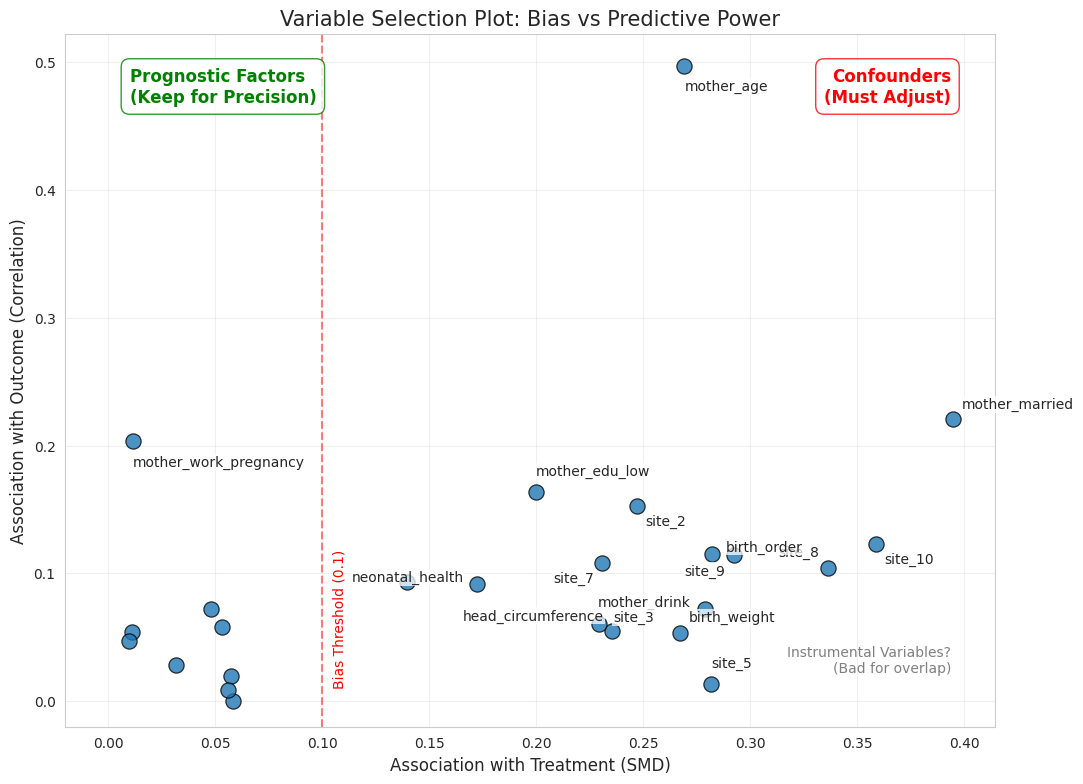

In [17]:
def plot_variable_selection_scatter(
    metrics_df: pd.DataFrame,
    smd_threshold: float = 0.1,
    k_bias: int = 15,
    k_prog: int = 10,
    label_mode: str = "union",  # "union" or "score"
):
    """
    変数の役割を分類するための散布図（ラベルは上位のみ）
    - x: Treatmentとの関連（SMD）値が大きいほどバイアスあり
    - y: アウトカムとの関連（相関）
    - 共変量名のラベルは見やすさを「SMD上位 + 相関上位」のみ表示
    """
    plt.figure(figsize=(12, 9))

    sns.scatterplot(
        data=metrics_df,
        x="SMD (Bias)",
        y="Correlation (Outcome)",
        s=120,
        alpha=0.8,
        edgecolor="black",
        zorder=2,
    )

    dfp = metrics_df.copy()

    # ---- ラベル対象を選ぶ ----
    if label_mode == "union":
        top_bias = set(dfp.nlargest(k_bias, "SMD (Bias)")["Feature"])
        top_prog = set(dfp.nlargest(k_prog, "Correlation (Outcome)")["Feature"])
        label_set = top_bias | top_prog
    elif label_mode == "score":
        # 単一スコアで上位を取る
        eps = 1e-12
        dfp["_score"] = (dfp["SMD (Bias)"] / (dfp["SMD (Bias)"].max() + eps)) + \
                        (dfp["Correlation (Outcome)"] / (dfp["Correlation (Outcome)"].max() + eps))
        label_set = set(dfp.nlargest(k_bias, "_score")["Feature"])
    else:
        raise ValueError("label_mode must be 'union' or 'score'")

    # ラベル描画
    # ラベルの重なりを減らすため、交互にオフセットを変える
    offsets = [(6, 6), (6, -6), (-6, 6), (-6, -6), (10, 0), (0, 10), (-10, 0), (0, -10)]
    labeled = dfp[dfp["Feature"].isin(label_set)].reset_index(drop=True)

    for i, row in labeled.iterrows():
        dx, dy = offsets[i % len(offsets)]
        plt.annotate(
            row["Feature"],
            (row["SMD (Bias)"], row["Correlation (Outcome)"]),
            textcoords="offset points",
            xytext=(dx, dy),
            ha="left" if dx >= 0 else "right",
            va="bottom" if dy >= 0 else "top",
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=1.0),
            zorder=3,
        )

    # 閾値ライン
    plt.axvline(x=smd_threshold, color="red", linestyle="--", alpha=0.5, zorder=1)
    plt.text(
        smd_threshold + 0.005,
        0.01,
        f"Bias Threshold ({smd_threshold})",
        color="red",
        rotation=90,
        va="bottom",
    )

    max_y = dfp["Correlation (Outcome)"].max() * 1.05
    max_x = dfp["SMD (Bias)"].max() * 1.05
    plt.xlim(-0.02, max_x)
    plt.ylim(-0.02, max_y)

    # 象限ラベル
    plt.text(
        0.01,
        max_y * 0.95,
        "Prognostic Factors\n(Keep for Precision)",
        ha="left",
        va="top",
        fontsize=12,
        fontweight="bold",
        color="green",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="green", boxstyle="round,pad=0.5"),
    )

    plt.text(
        max_x * 0.95,
        max_y * 0.95,
        "Confounders\n(Must Adjust)",
        ha="right",
        va="top",
        fontsize=12,
        fontweight="bold",
        color="red",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="red", boxstyle="round,pad=0.5"),
    )

    plt.text(
        max_x * 0.95,
        0.02,
        "Instrumental Variables?\n(Bad for overlap)",
        ha="right",
        va="bottom",
        fontsize=10,
        color="gray",
    )

    plt.title("Variable Selection Plot: Bias vs Predictive Power", fontsize=15)
    plt.xlabel("Association with Treatment (SMD)", fontsize=12)
    plt.ylabel("Association with Outcome (Correlation)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()


#SMD x アウトカムとの相関の散布図出力
plot_variable_selection_scatter(metrics_df, smd_threshold=0.1, k_bias=15, k_prog=10)


### このセクションで分かったこと
- 各共変量の分布比較
  - mother_ageやbirth_weightなど一部共変量では介入群と対照群で分布が異なり選択バイアスがありそう
- アウトカムの単純比較
  - アウトカムについては介入群のほうが明確に大きいが未調整のアウトカムのため交絡が混ざる。そのため介入効果の結論には使えない
- SMD x アウトカムとの相関プロット
  - mother_ageを代表として交絡因子が複数ありそう。交絡因子は傾向スコアの計算に入れる
  - mother_work_pregnancyは予後因子になっていそう。これは推定安定化のためにぜひモデルに入れたい
  - 右下の共変量は操作変数の可能性もある。ただし、ドメイン知識なしに操作変数と断定して除外するのは難しい。実務でドメイン知識があれば、除外を検討するが今回はこの後の診断でoverlap・ESSを確認しているので、問題があれば検出できる設計になっており、除外せずに進める方針とした。
  

<操作変数の判断について補足><br>
仮に「操作変数だから」と判断して除外した変数が、実は強い交絡因子だった場合、未調整交絡により致命的なバイアスが生じます。
一方で、操作変数を調整に含めると、傾向スコアが極端になりやすく、重み付け推定の分散が増えて不安定化するリスクがあります（状況によってはバイアス面の懸念もあります）。

今回は群間の調整には後続で述べるoverlap weightsを採用しています。これは「傾向スコアが極端なサンプル」の重みを自動的に下げる性質があり、極端PSに起因する不安定性を相対的に軽減しやすい設計です。
ただし完全に防げるわけではないため、後続の診断（Love plot / ESS / 重み分布）で不安定化の兆候がないかを必ず確認し、問題があればPSモデルやtrimmingの見直しで対応します。




# **2. 傾向スコアによる共通サポートの事前診断と外挿回避の設計（トリミング）**
### 本セクションの分析目的
このセクションでは、**そもそもこのデータで uplift modelingが成立しそうか**を確認します。  
ポイントは、介入群と対照群が **比較可能な共通サポート（分布の重なり）** を十分に持っているかどうかです。

共通サポートが小さい（= PS が 0/1 に極端に近い観測が多い）場合、  
反対側の群に「似た人」がほとんど存在せず、推定が **データからの比較ではなく外挿**になりやすいという欠点があります。
その結果、upliftの推定や policyの評価が不安定になりやすいため、ここで事前診断を行っています。

ここで **共通サポートが限定的**だと判断した場合、  
このまま uplift modeling を行うと推定が不安定になる可能性が高いため、傾向スコアが極端な層を推定から除外するトリミング処理を行います（必要に応じて重み付け設計も）。



## **2.1 傾向スコアによる共通サポート診断**
<確認手順>
- 共変量 `X` から介入確率 `ps = P(T=1|X)` を推定（**OOF で予測しリークを回避**）
- treated / control の件数と平均PSを確認し、**介入定義の整合性**をチェック
- `ps < 0.05` や `ps > 0.95` の割合を見て、**極端な割当が多くないか**確認
- treated / control の PS レンジと **共通サポート比率**を定量化
- PS 分布を可視化し、群間の重なりを直感的に確認

介入群・対照群のN数と傾向スコア平均値の確認
N treated: 139 | N control: 608
Mean PS treated: 0.2534 | control: 0.1726
傾向スコアの共通サポート、極端な数値の比率確認


,trim_threshold,ps_mean,ps_std,ps_min,ps_max,extreme_ratio
0,0.05,0.187587,0.14325,0.003819,0.675041,0.164659


,treated_min,treated_max,control_min,control_max,overlap_min,overlap_max,has_overlap,common_support_ratio_all,common_support_ratio_treated,common_support_ratio_control
0,0.003819,0.600793,0.004884,0.675041,0.004884,0.600793,True,0.98929,0.992806,0.988487


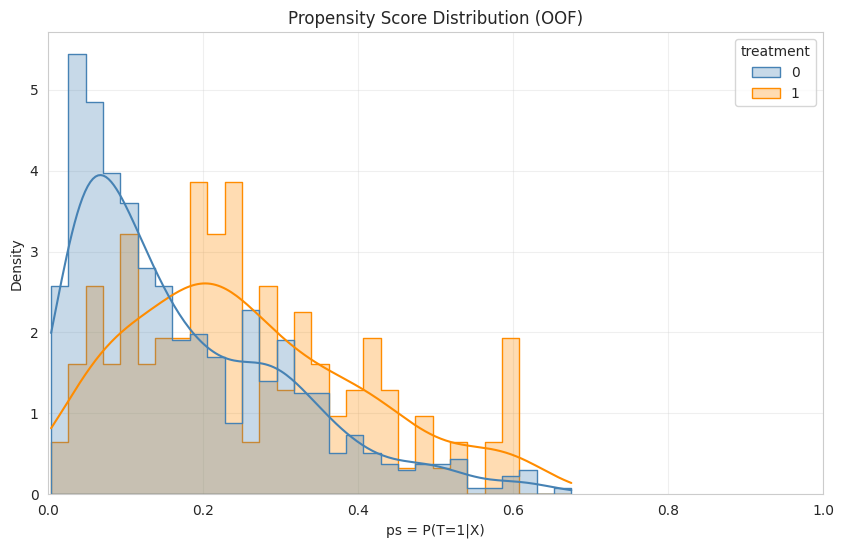

In [18]:
def _make_ps_model(seed: int = SEED) -> Pipeline:
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=seed, max_iter=2000, solver="lbfgs")),
    ])

def compute_propensity_scores_oof(
    df: pd.DataFrame,
    features: List[str],
    treatment_col: str = COL_TREAT,
    cv: int = 5,
    seed: int = SEED,
    fillna_value: float = 0.0,
) -> np.ndarray:
    X = df[features].copy()
    t = df[treatment_col].astype(int).to_numpy()

    if X.isnull().sum().sum() > 0:
        X = X.fillna(fillna_value)

    model = _make_ps_model(seed)
    model.fit(X, t)
    classes = model.named_steps["clf"].classes_

    cv_obj = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    try:
        proba = cross_val_predict(model, X, t, cv=cv_obj, method="predict_proba")
    except Exception:
        print("CV failed -> fallback to in-sample fit.")
        proba = model.predict_proba(X)

    proba_df = pd.DataFrame(proba, columns=classes)
    if 1 not in proba_df.columns:
        raise ValueError("Class '1' not found in predict_proba outputs. Check coding.")
    return proba_df[1].to_numpy(dtype=float)

def summarize_ps_extremes(ps: np.ndarray, trim: float = 0.05) -> pd.DataFrame:
    ps = np.asarray(ps, dtype=float)
    extreme = (ps < trim) | (ps > 1 - trim)
    return pd.DataFrame([{
        "trim_threshold": trim,
        "ps_mean": float(np.mean(ps)),
        "ps_std": float(np.std(ps)),
        "ps_min": float(np.min(ps)),
        "ps_max": float(np.max(ps)),
        "extreme_ratio": float(np.mean(extreme)),
    }])

def overlap_metrics(ps: np.ndarray, t: np.ndarray) -> pd.DataFrame:
    t = np.asarray(t, dtype=int)
    ps = np.asarray(ps, dtype=float)
    ps_t, ps_c = ps[t == 1], ps[t == 0]

    t_min, t_max = float(ps_t.min()), float(ps_t.max())
    c_min, c_max = float(ps_c.min()), float(ps_c.max())
    overlap_min = max(t_min, c_min)
    overlap_max = min(t_max, c_max)
    in_support = (ps >= overlap_min) & (ps <= overlap_max)

    return pd.DataFrame([{
        "treated_min": t_min, "treated_max": t_max,
        "control_min": c_min, "control_max": c_max,
        "overlap_min": overlap_min, "overlap_max": overlap_max,
        "has_overlap": bool(overlap_min < overlap_max),
        "common_support_ratio_all": float(in_support.mean()),
        "common_support_ratio_treated": float(in_support[t == 1].mean()),
        "common_support_ratio_control": float(in_support[t == 0].mean()),
    }])

def plot_ps_overlap(df: pd.DataFrame, ps: np.ndarray, treatment_col: str = COL_TREAT):
    tmp = df[[treatment_col]].copy()
    tmp["ps_score"] = ps

    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=tmp, x="ps_score", hue=treatment_col,
        element="step", stat="density", common_norm=False,
        bins=30, alpha=0.3, kde=True, palette=COLOR_PALETTE
    )
    plt.title("Propensity Score Distribution (OOF)")
    plt.xlabel("ps = P(T=1|X)")
    plt.ylabel("Density")
    plt.xlim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.show()

ps = compute_propensity_scores_oof(df, features, cv=5, seed=SEED)
t = df[COL_TREAT].astype(int).to_numpy()

print("介入群・対照群のN数と傾向スコア平均値の確認")
print("N treated:", int((t==1).sum()), "| N control:", int((t==0).sum()))
print("Mean PS treated:", ps[t==1].mean().round(4), "| control:", ps[t==0].mean().round(4))

print("傾向スコアの共通サポート、極端な数値の比率確認")
display(summarize_ps_extremes(ps, trim=0.05))
display(overlap_metrics(ps, t))
plot_ps_overlap(df, ps)


### 結果解釈
- 共通サポート比率は約98%と高いものの傾向スコアの分布は両群で異なり、特に傾向スコアが0付近のデータが多いため推定が不安定になる可能性はある。よって一定トリミングによって傾向スコアが極端な層を除外する処理は必要そう
- トリミング閾値を0.05としたときの、extreme_ratio（傾向スコアが0.05以下、0.95以上）の割合は16.5%。つまりこのトリミング閾値を採用する場合は16.5%のデータが除外される(この除外割合をdrop率とする）
- トリミングをするのであれば共通サポートは十分に確保されてるため、uplift modelingは可能そう

### **2.2 トリミング候補の比較（drop率の確認）**
2.1で推定した傾向スコアを使い、スコアが極端なサンプル（比較が難しい領域）を除外するためのトリミング閾値を検討する。  
ここではまず、候補となる閾値（例: `0.03 / 0.05 / 0.10`）ごとに **どれだけデータが削られるか（drop率）**を定量化する。

- トリミング条件：`trim <= ps <= 1-trim`（PSが0/1に近すぎる個体を除外）
- drop率を **全体 / treated / control** で算出 （どちらの群が多く削られるかが重要なため）
- 実務では基本は `0.05` など固定で進め、drop率が大きい／後段で重みが不安定などの赤信号が出たときのみ感度分析することが多い


In [19]:
#drop率が大きい・SMDが改善しない・重みが不安定といった赤信号が出た場合にだけ、0.03/0.07などへ感度確認
def trimming_drop_table(df: pd.DataFrame, ps: np.ndarray, trim_list=(0.03, 0.05, 0.10), treatment_col: str = COL_TREAT) -> pd.DataFrame:
    t = df[treatment_col].astype(int).to_numpy()
    n_all = len(df)
    n_t = int((t == 1).sum())
    n_c = int((t == 0).sum())

    rows = []
    for trim in trim_list:
        keep = (ps >= trim) & (ps <= 1 - trim)
        kept_all = int(keep.sum())
        kept_t = int(((t == 1) & keep).sum())
        kept_c = int(((t == 0) & keep).sum())
        rows.append({
            "trim": float(trim),
            "drop_%_all": 100.0 * (1 - kept_all / n_all),
            "drop_%_treat": 100.0 * (1 - kept_t / n_t) if n_t else 0.0,
            "drop_%_ctrl": 100.0 * (1 - kept_c / n_c) if n_c else 0.0,
            "kept_all": kept_all,
        })
    return pd.DataFrame(rows)

drop_tbl = trimming_drop_table(df, ps, trim_list=(0.03, 0.05, 0.10))
display(drop_tbl)



,trim,drop_%_all,drop_%_treat,drop_%_ctrl,kept_all
0,0.03,7.496653,1.438849,8.881579,691
1,0.05,16.465863,6.474820,18.750000,624
2,0.10,35.876841,18.705036,39.802632,479


トリミング閾値が0.05の場合、介入群・対照群のdrop率はそれぞれ6.5%、18.8%。閾値0.03だとdrop率は低いものの極端は傾向スコアにより推定が不安定化するリスクを考慮して0.05を採用して進める。

### 2.3 trim 後データ作成（以降の診断・重み付けの土台）
選んだトリミング閾値で `df_trim` と `ps_trim` を作成し、以降の解析の土台を確定する（推定対象の母集団と使用する傾向スコアの確定）

- サンプル数と介入比率が大きく変わっていないかを確認  
- 以降の **バランス調整とLove plot/ESSによる診断**はトリミング後データで実施する

In [20]:
TRIM = 0.05
keep = (ps >= TRIM) & (ps <= 1 - TRIM)

df_trim = df.loc[keep].copy()
ps_trim = ps[keep]
t_trim = df_trim[COL_TREAT].astype(int).to_numpy()

print("After trimming:", df_trim.shape, "| treated ratio:", df_trim[COL_TREAT].mean().round(4))


After trimming: (624, 32) | treated ratio: 0.2083


## **3. バランス調整（overlap weights）と診断：Love plot + ESS**
このセクションでは、**トリミング後データ `df_trim`** に対して、傾向スコア `ps_trim` から  
**overlap weights（ATO）** を計算し、次の2点を診断する。

1) **調整によって共変量バランスが十分に改善しているか**  
2) **重み付けにより推定が不安定になりそうな兆候（有効サンプルの極端な減少）がないか**

### overlap weightsとは

overlap weights（ATO）は、各サンプル $i$ について次で定義する：  
傾向スコアを
$$
e(x) = P(T=1 \mid X=x)
$$
とする。

overlap weights は各サンプル $i$ に対して
$$
w_i =
\begin{cases}
1 - e(x_i) & (T_i = 1) \\
e(x_i) & (T_i = 0)
\end{cases}
$$
で定義する。

重み付けは「各サンプルの値に $w_i$ を掛けて平均を取る」ことで行う：
$$
\text{Weighted mean}=\frac{\sum_i w_i\,Y_i}{\sum_i w_i}.
$$

これは直感的には、両群が重なって比較しやすい領域（overlap）を強調する重み付けの発想です。  
その結果、推定対象は **比較可能な重なり領域における平均効果（ATO）** と考えてよいです。さらに今回はトリミングで極端な観測を先に除いているため、**トリミング後の範囲に限定されたATO** が推定対象になります。

ただし観察データでは、重み付けは「バイアス補正」に有効な一方で、重みが一部のサンプルに集中すると分散が増え、推定が不安定になりやすいです。  
そのため、**バランス改善（Bias）と安定性（Variance）の両方**を同時に確認しています。

---

### Love plot（Raw vs Trim-only vs Weighted）
- **目的**：共変量の分布差（選択バイアス）が、調整後にどれだけ縮まったかを可視化する
- **比較内容**：
  - `Raw`：重み付け前（※本Notebookでは **トリミング前の全体 `df`** をRawとして表示）
  - `Trim-only`：**トリミング後の `df_trim`（重み付けなし）**
  - `Weighted`：trim後の `df_trim` に overlap weights を適用したもの
- **読み方**：
  - **SMD が小さいほどバランスが良い**
  - 目安として **SMD < 0.1** の特徴量が増えるほど、群間のズレが縮まっていると解釈する

---

### ESS（Effective Sample Size）
- **目的**：重みが一部サンプルに集中していないか（= 推定が不安定になりうるか）を点検する
- **確認内容**：
  - treated / control 別に ESS を算出し、`ESS/N` が十分か（極端に小さくないか）を確認
  - 併せて `w_mean / w_std / w_max` を見て、重みが暴れていないかをチェックする

#### ESSの補足
重み付け推定では、全サンプル数Nが同じでも、重みが一部のサンプルに集中すると「実質的に効いているサンプル数」が小さくなります。この「実質的に何サンプル分の情報量があるか」を表す指標が ESS（Effective Sample Size） です。

直感的には、
- 重みが均等（ほぼ同じ）なら、ESS はサンプル数 Nに近い  
- 重みが偏る（一部だけ極端に大きい）ほど、ESS は小さくなり、推定の分散が増えて不安定になりやすい  

そのため本Notebookでは、treated / control 別に ESS を算出し、ESS/N が極端に小さくないかを確認しています。  
さらに補助的に w_mean / w_std / w_max を見て、重みのばらつきや極端値（暴れ）がないかも点検しています。

---

### この診断結果をどう設計に反映するか
- Love plot で **SMD が十分に縮まる** かつ ESS が極端に小さくない  
  → 次のセクションへ進み、効果の異質性チェックや（ATO寄りの）設計で uplift / policy 評価を行う
- バランス改善が弱い／ESS が小さすぎる（重みが偏る）  
  → trimming 閾値や PS モデルを見直す（外挿・不安定を避ける）


In [28]:
# =========================================================
# Utils: numeric safe + weighted moments + SMD
# =========================================================
def _safe_numeric(x: pd.Series) -> np.ndarray:
    """numeric化→欠損はmedian埋め（全欠損なら0）"""
    x = pd.to_numeric(x, errors="coerce")
    if x.isnull().all():
        return np.zeros(len(x), dtype=float)
    return x.fillna(x.median()).to_numpy(dtype=float)

def _wmean(x: np.ndarray, w: np.ndarray) -> float:
    sw = float(np.sum(w))
    return float(np.sum(w * x) / sw) if sw > 0 else np.nan

def _wvar(x: np.ndarray, w: np.ndarray) -> float:
    """Love plot用途の簡易な重み付き分散（不偏補正なし）"""
    mu = _wmean(x, w)
    sw = float(np.sum(w))
    return float(np.sum(w * (x - mu) ** 2) / sw) if sw > 0 else np.nan

def smd_unweighted(x: np.ndarray, t: np.ndarray) -> float:
    """unweighted SMD"""
    x_t, x_c = x[t == 1], x[t == 0]
    mt, mc = float(np.mean(x_t)), float(np.mean(x_c))
    vt = float(np.var(x_t, ddof=1)) if len(x_t) > 1 else 0.0
    vc = float(np.var(x_c, ddof=1)) if len(x_c) > 1 else 0.0
    pooled = float(np.sqrt((vt + vc) / 2.0))
    return float(abs((mt - mc) / pooled)) if pooled > 0 else 0.0

def smd_weighted(x: np.ndarray, t: np.ndarray, w: np.ndarray) -> float:
    """weighted SMD (overlap weights only; on trimmed set)"""
    x_t, w_t = x[t == 1], w[t == 1]
    x_c, w_c = x[t == 0], w[t == 0]
    mt, mc = _wmean(x_t, w_t), _wmean(x_c, w_c)
    vt, vc = _wvar(x_t, w_t), _wvar(x_c, w_c)
    pooled = float(np.sqrt((vt + vc) / 2.0))
    return float(abs((mt - mc) / pooled)) if pooled > 0 else 0.0

# =========================================================
# ESS utilities
# =========================================================
def effective_sample_size(w: np.ndarray) -> float:
    """ESS = (sum w)^2 / sum(w^2)"""
    w = np.asarray(w, dtype=float)
    s1 = float(np.sum(w))
    s2 = float(np.sum(w * w))
    return float((s1 * s1) / s2) if s2 > 0 else 0.0

def summarize_ess_by_group(t: np.ndarray, w: np.ndarray) -> pd.DataFrame:
    """treated/control 別に ESS を要約"""
    t = np.asarray(t, dtype=int)
    w = np.asarray(w, dtype=float)

    rows = []
    for g, name in [(1, "Treated"), (0, "Control")]:
        mask = (t == g)
        n = int(mask.sum())
        w_g = w[mask]
        ess = effective_sample_size(w_g) if n > 0 else 0.0
        rows.append({
            "Group": name,
            "N": n,
            "ESS": ess,
            "ESS_ratio(ESS/N)": (ess / n) if n > 0 else 0.0,
            "w_mean": float(np.mean(w_g)) if n > 0 else 0.0,
            "w_std": float(np.std(w_g)) if n > 0 else 0.0,
            "w_max": float(np.max(w_g)) if n > 0 else 0.0,
        })
    return pd.DataFrame(rows)

# =========================================================
# Overlap weights (ATO-like)
# =========================================================
def compute_overlap_weights(ps: np.ndarray, t: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    overlap weights（ATO寄り）
      treated: 1 - ps
      control: ps
    """
    ps = np.clip(np.asarray(ps, dtype=float), eps, 1 - eps)
    t = np.asarray(t, dtype=int)
    return np.where(t == 1, 1.0 - ps, ps).astype(float)



[ESS by group] (trimmed set, overlap weights / ATO-like)
  Group   N        ESS  ESS_ratio(ESS/N)   w_mean    w_std    w_max
Treated 130 125.195149          0.963040 0.731609 0.143326 0.948466
Control 494 348.805747          0.706085 0.205133 0.132348 0.675041


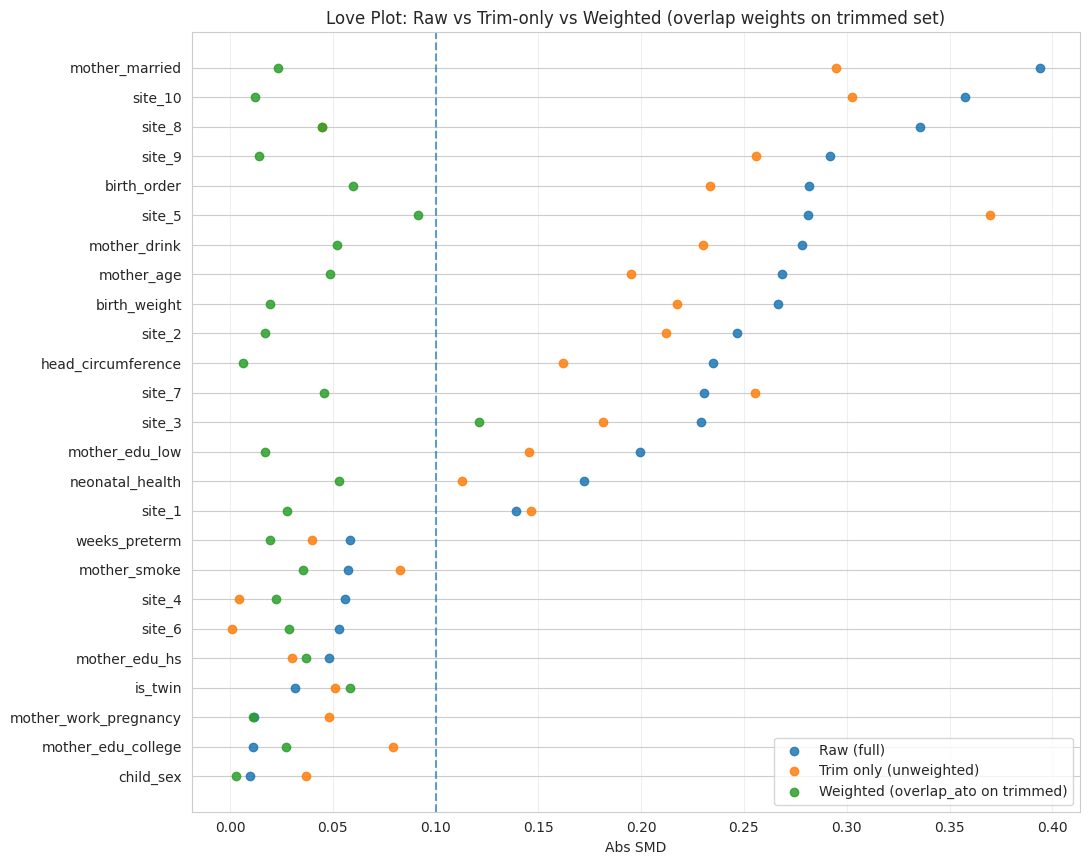


[Share of features with SMD>=0.1]
Raw       : 0.64
Trim only : 0.6
Weighted  : 0.04


,feature,SMD_raw,SMD_trim_only,SMD_weighted(overlap_ato)
8,mother_married,0.393832,0.294631,0.023180
24,site_10,0.357571,0.302520,0.012357
22,site_8,0.335743,0.044855,0.044992
23,site_9,0.291725,0.255672,0.013968
3,birth_order,0.281617,0.233528,0.060070
19,site_5,0.281139,0.369638,0.091409
13,mother_drink,0.278155,0.230150,0.051878
5,mother_age,0.268561,0.194983,0.048874
0,birth_weight,0.266746,0.217371,0.019646
16,site_2,0.246530,0.212277,0.017162


In [29]:
# =========================================================
# Love plot: Raw vs Trim-only vs Weighted(on trimmed) + ESS print
# =========================================================

def love_plot_raw_trim_weighted(
    df_raw: pd.DataFrame,
    df_trim: pd.DataFrame,
    features: List[str],
    ps_trim: np.ndarray,
    treatment_col: str,
    top_k: int = 25,
    smd_th: float = 0.1,
):
    """
    Love plot: Raw（全体） vs Trim-only（trim後unweighted） vs Weighted（trim後にoverlap weights）
    - トリミングの効果（Raw→Trim）と、重み付けの効果（Trim→Weighted）を分離して見せる
    - ★追加: weighted(=trim後+overlap)のESSを treated/control 別に出す
    """
    # group labels
    t0 = df_raw[treatment_col].astype(int).to_numpy()
    t1 = df_trim[treatment_col].astype(int).to_numpy()

    # overlap weights: トリミング後に適用
    w1 = compute_overlap_weights(ps_trim, t1)

    # ESS（トリミング後 & overlap weights）
    ess_tbl = summarize_ess_by_group(t1, w1)
    print("\n[ESS by group] (trimmed set, overlap weights / ATO-like)")
    print(ess_tbl.to_string(index=False))

    rows = []
    for col in features:
        if col not in df_raw.columns or col not in df_trim.columns:
            continue
        if not np.issubdtype(df_raw[col].dtype, np.number):
            continue

        # raw（全体）
        x0 = _safe_numeric(df_raw[col])
        # trim（トリミング後・重みなし）
        x1 = _safe_numeric(df_trim[col])

        rows.append({
            "feature": col,
            "SMD_raw": smd_unweighted(x0, t0),
            "SMD_trim_only": smd_unweighted(x1, t1),
            "SMD_weighted(overlap_ato)": smd_weighted(x1, t1, w1),
        })

    res = pd.DataFrame(rows)

    # 表示する特徴量を上位に限定（みやすさ考慮のため）
    res = res.sort_values("SMD_raw", ascending=False)
    show = res.head(top_k).sort_values("SMD_raw", ascending=True)

    # plot
    plt.figure(figsize=(11, max(5, 0.35 * len(show))))
    y = np.arange(len(show))

    plt.scatter(show["SMD_raw"], y, label="Raw (full)", alpha=0.85)
    plt.scatter(show["SMD_trim_only"], y, label="Trim only (unweighted)", alpha=0.85)
    plt.scatter(show["SMD_weighted(overlap_ato)"], y, label="Weighted (overlap_ato on trimmed)", alpha=0.85)

    plt.yticks(y, show["feature"])
    plt.axvline(smd_th, linestyle="--", alpha=0.7)
    plt.xlabel("Abs SMD")
    plt.title("Love Plot: Raw vs Trim-only vs Weighted (overlap weights on trimmed set)")
    plt.grid(True, axis="x", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n[Share of features with SMD>=0.1]")
    print("Raw       :", (res["SMD_raw"] >= smd_th).mean().round(3))
    print("Trim only :", (res["SMD_trim_only"] >= smd_th).mean().round(3))
    print("Weighted  :", (res["SMD_weighted(overlap_ato)"] >= smd_th).mean().round(3))

    display(res.head(20))
    return res, ess_tbl


# loveplot作成実行
balance_tbl, ess_tbl = love_plot_raw_trim_weighted(
    df_raw=df,
    df_trim=df_trim,
    features=features,
    ps_trim=ps_trim,
    treatment_col=COL_TREAT,
    top_k=25,
    smd_th=0.1,
)


トリミング後データに overlap weights を適用した結果（ESS/N）：
- ESS比率（介入群）：約 96.3%
- ESS比率（対照群）：約 70.6%

いずれも極端な低下は見られず、推定の安定性という観点で許容範囲と判断してます。

Love plot（SMD）では、調整後に SMD ≥ 0.1 の共変量は site_3 のみであり、共変量バランスが改善していることを確認しています


## 4. 層別分析による効果の異質性の簡易チェック

このセルは、uplift/反実仮想推定に進む前に **「効果が一様ではなさそうか？」** をラフに確認するための簡易チェック。  
※極端なPS領域は外挿になりやすいため、ここでは **トリミング後データ `df_trim`** を用いて“比較しやすい範囲”で傾向を見ます。

### 何をしているか（heterogeneity_quartile_check）
指定した代表特徴量 `feature`（例：`birth_weight`）でサンプルを **分位（q=4なら四分位）** に分け、各ビンごとに

- `E[Y | T=1, bin]`（介入群の平均アウトカム）
- `E[Y | T=0, bin]`（対照群の平均アウトカム）
- **差分** `diff_(T-C) = E[Y|T=1,bin] - E[Y|T=0,bin]`

を計算してテーブル表示し、さらに差分を棒グラフで可視化する。

### どう解釈するか
- **diff_(T-C) がビンによって大きく変わる**  
  → 効果が一様ではない“兆候”がありそう（upliftの動機づけになる）
- **どのビンでも差がほぼ同じ**  
  → 効果が一様っぽい（upliftの価値が小さい可能性）

もっと簡潔にいうとここでは**upliftに進む前の「uplift modelingする価値がありそうか？」のスクリーニング**をしています。

uplift（= 個人ごとの効果差でターゲティングする）をやる価値があるのは、「誰に効くか／効かないか」が人によって違うときです。

この簡易チェックは
- 効果が一様っぽい？
- 人（特徴量の層）によって効き方が違いそう？
をざっくり見て、upliftに進む価値がありそうかをスクリーニングしています。

### 注意点（このチェックの限界）
- これは **未調整（naive）な平均差** なので、交絡があると因果効果そのものではない


（例）`birth_weight` で四分位に切って、ビン別の差分を確認する：
```python
heterogeneity_quartile_check(df_trim, "birth_weight")
```


--mother_age------------------------


/tmp/ipython-input-2087419568.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby(["bin", treatment_col])[outcome_col].mean().unstack(treatment_col)


treatment,bin,0,1,diff_(T-C)
0,"(-1.852, -0.692]",1.472,5.571,4.099
1,"(-0.692, -0.030]",1.839,6.531,4.692
2,"(-0.030, 0.798]",2.653,6.650,3.997
3,"(0.798, 2.951]",4.058,6.711,2.653


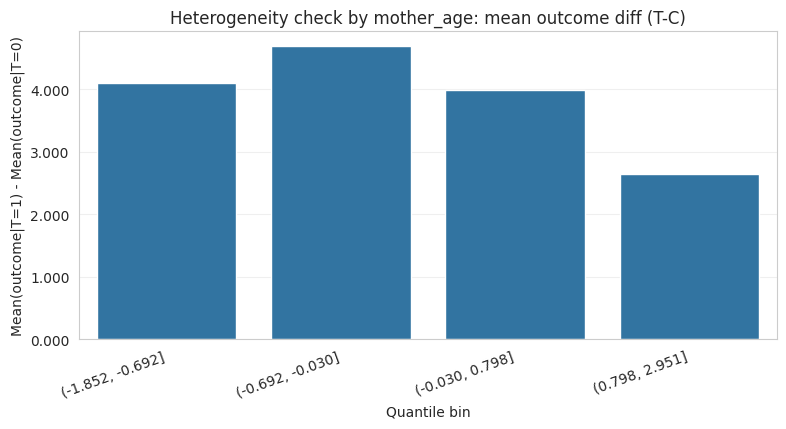

--birth_weight------------------------


/tmp/ipython-input-2087419568.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby(["bin", treatment_col])[outcome_col].mean().unstack(treatment_col)


treatment,bin,0,1,diff_(T-C)
0,"(-2.732, -0.548]",2.394,6.587,4.193
1,"(-0.548, 0.230]",2.407,6.578,4.171
2,"(0.230, 0.879]",2.368,6.416,4.048
3,"(0.879, 1.505]",2.430,6.157,3.727


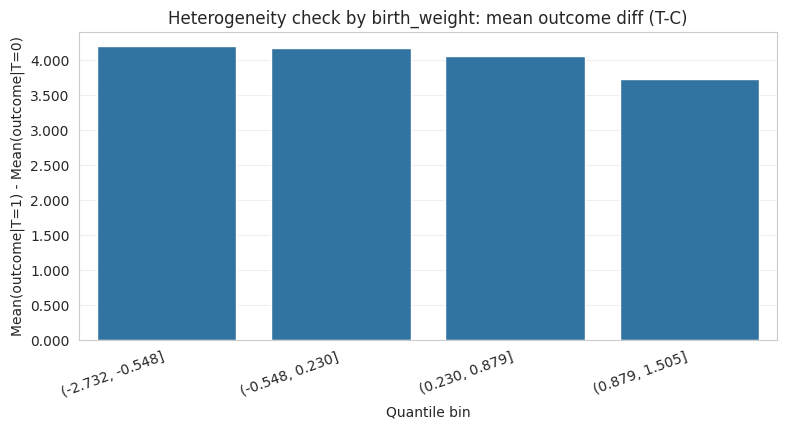

In [25]:
def heterogeneity_quartile_check(
    df: pd.DataFrame,
    feature: str,
    treatment_col: str = COL_TREAT,
    outcome_col: str = COL_Y,
    q: int = 4,
    decimals: int = 3,
):
    tmp = df[[feature, treatment_col, outcome_col]].copy().dropna()

    try:
        tmp["bin"] = pd.qcut(tmp[feature], q=q, duplicates="drop")
    except Exception as e:
        print(f"qcut failed: {e}")
        return None

    # bin(区間表示)も小数点を揃える
    fmt = f"{{:.{decimals}f}}"
    cats = tmp["bin"].cat.categories
    new_cats = [f"({fmt.format(iv.left)}, {fmt.format(iv.right)}]" for iv in cats]
    tmp["bin"] = tmp["bin"].cat.rename_categories(new_cats)

    g = tmp.groupby(["bin", treatment_col])[outcome_col].mean().unstack(treatment_col)
    if 0 not in g.columns or 1 not in g.columns:
        print("Both groups not present in bins. Pick another feature.")
        return None

    g["diff_(T-C)"] = g[1] - g[0]
    g = g.reset_index()

    # 数値列を丸め（binは文字列カテゴリなのでそのまま）
    g_out = g.copy()
    num_cols = [c for c in g_out.columns if c != "bin"]
    g_out[num_cols] = g_out[num_cols].round(decimals)
    display(g_out)

    plt.figure(figsize=(9, 4))
    ax = sns.barplot(data=g, x="bin", y="diff_(T-C)")
    plt.title(f"Heterogeneity check by {feature}: mean outcome diff (T-C)")
    plt.xlabel("Quantile bin")
    plt.ylabel("Mean(outcome|T=1) - Mean(outcome|T=0)")
    plt.xticks(rotation=20, ha="right")
    plt.grid(axis="y", alpha=0.3)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter(f"%.{decimals}f"))
    plt.show()

# 代表特徴量でいくつか示してます
col_list = ['mother_age', 'birth_weight']
for col in col_list:
  print(f"--{col}------------------------")
  heterogeneity_quartile_check(df_trim, col)

## EDA結果サマリ（設計判断が分かるポイント整理）

目的：uplift modeling（Top-Kターゲティング）に進む前に、  
**(1) 選択バイアスの大きさ**、**(2) 共通サポート（overlap）**、**(3) トリミングと重み付け後のバランスと安定性（ESS）** を確認し、  **固定トリミング（trim=0.05）＋ overlap weights（overlap領域を重視した学習・診断）** を採用する根拠を整理してEDAのまとめとしています。

---

### 1. 選択バイアスの兆候（調整なし比較の限界）
- 処置群（N=139）と対照群（N=608）で共変量分布に差があり、**選択バイアスが疑われる**。
- アウトカムの単純比較では処置群の平均が高い。ただし**未調整の差**であり因果効果の結論までは言えません。

**補足（変数の役割の直感的な整理：SMD × アウトカム相関）**
- `mother_age` や `birth_weight` を代表として、**交絡因子が複数ありそう** → 傾向スコア推定に含める方針とする。
- `mother_work_pregnancy` は **予後因子（アウトカムに効くが処置割当に強くは効かない）**の可能性 → 推定安定化のためモデルに含めたい。
- 一部は操作変数の可能性もあるが、ドメイン知識なしに操作変数と断定して除外するのは難しい。今回はこの後の診断でoverlap・ESSを確認しているので、問題があれば検出できる設計になっており、除外せずに進める方針としました

---

### 2. 傾向スコア診断（トリミング前）：共通サポートと外挿リスク
- OOFで傾向スコアを推定し、割当が共変量に依存していそうかを確認。
- 共通サポート比率は約98%と高い一方、PS分布は両群で異なり、特に **PSが0付近に偏った観測が一定数**存在。
- `ps < 0.05` または `ps > 0.95` の **extreme_ratio（= drop率に相当）が 16.5%**。  
  → 極端PSは外挿になりやすく、重み付け（特にIPW系）では分散が増えて推定が不安定化する懸念。

**判断**：共通サポートはあるのでuplift modeling自体は可能そうだが、**極端PSの影響を抑える設計（トリミング前提）が必要**。

---

### 2.2 トリミング候補の比較とトリミング閾値の決定
- `trim = 0.05` の場合：
  - drop率（処置群）：**6.5%**
  - drop率（対照群）：**18.8%**
  - 全体drop率：**16.5%**
- `trim = 0.03` は drop率は下がるが、極端PSを残しやすく **不安定化リスク**が残る懸念があります。

**判断**：本Notebookでは **固定 trimming（trim=0.05）** を採用し、以降の診断と学習の土台 `df_trim` を作成する。

---

### 3. バランス調整（overlap weights）と診断：Love plot + ESS
- trimming後データ `df_trim` に対して、傾向スコアから **overlap weights** を適用。  
  overlap weights は **PSが0.5付近の“比較可能性が高い領域（overlap）”を相対的に重視**し、外挿リスクの高い領域（PSが極端な観測）の影響を弱める重み付け（例：処置群は \(1-e(x)\)、対照群は \(e(x)\)）。
- その結果、重み付けを用いた推定や学習は **overlap領域を重視した（ATO寄りの）挙動**になりやすい。  
  ただし本分析では、重み付けは主に「学習の安定化・バランス改善」のために利用し、**最終的な意思決定評価（Policy Value）は trim後集団（ATE@trim）に対してAIPWで統一**して比較する。

**安定性（ESS）**
- overlap weights適用後の ESS/N：
  - ESS比率（処置群）：**約96.3%**
  - ESS比率（対照群）：**約70.6%**
- いずれも極端な低下は見られず、**推定の安定性という観点で許容範囲**と判断。

**バランス（Love plot / SMD）**
- Love plotでは **Raw（全体） / Trim-only（trim後・重みなし） / Weighted（trim後+overlap weights）** を比較。
- 調整（Weighted）後に **SMD ≥ 0.1** の共変量は **`site_3` のみ**。  
  → **共変量バランスが大きく改善**していることを確認。

**判断**：バランス（Bias）と安定性（Variance）の両面で大きな赤信号はなく、  
**「trim=0.05 + overlap weights（overlap領域を重視した学習・診断）」**で次工程（uplift / policy評価）へ進むのが妥当と判断しています

---

### 4. 効果の異質性（簡易チェック）：upliftに進む動機づけ
- upliftは「効く人に絞る」ため、**効果が一様だと改善余地が小さい**。  
  そこで `df_trim` を用い、代表特徴量で層別した **未調整の T−C 差の“パターン”**を探索的に確認。
- 例（四分位ビンの naive差）：
  - `mother_age`：ビンにより差が変動（例：diffが **約4.69 → 2.65** と変化）
  - `birth_weight`：ビンにより差が変動（例：diffが **約4.19 → 3.73** と変化）
- これは因果効果そのものではない（未調整）ものの、**効果が一様ではない兆候**が見られ、uplift modeling（ターゲティング最適化）に進むモチベーションはあると判断しました。

---

### 5. モデリング設計判断

#### EDA結果に基づく設計判断
- **前処理**：固定トリミング（`閾値=0.05`）を採用。
- **学習・診断**：overlap weightsによりバランス改善（SMD）と安定性（ESS）を両立させ、**overlap領域を意識した安定なランキング学習**を狙う。

#### 問題設定に基づく設計判断（評価設計）
- 次のモデリング工程では：
  - upliftスコアは **policy作成の中間表現**
  - 最終判断は **同一の DR/AIPW 評価器による Policy Value（Top-Kの期待効果）** を主指標とする（※評価は trim後集団＝ATE@trim を想定）
  - AUUC / Qini は参考指標（ランキング健全性チェック）として併用する
